# Racist Deeds - EDA

## Nathaniel Quisel, Jianying Liu, Jacob Stein

### Project Description

The Racist Deeds Project aims to expand the identification of property deeds with racist restrictions, initially focusing on Longmeadow, Massachusetts. These restrictions, targeting marginalized groups like African Americans, were outlawed by the Fair Housing Act of 1968 and locally in Massachusetts by 1946. This project seeks to streamline the identification process of discriminatory deeds to support the Longmeadow Historical Society.

The focus of this semester is to build a data pipeline that will interact with deeds stored in a designated Google Drive location and potentially adjust some of the Gen AI prompts. The project will implement Optical Character Recognition (OCR) tools via a Python package to digitize and extract text from scanned deed documents, which will facilitate more efficient analysis and pattern recognition. Additionally, there will be an effort to refine and adjust the Gen AI prompts to improve the mapping (property).

### Data Description

The dataset is stored in Google Drive, and consists of housing deeds from in and around Longmeadow, Massachusetts from the 19th and 20th century. The 20th century deeds are mostly typed and follow a more standard format, whereas the 19th century deeds are written and less structured.

### Loading and Preprocessing

Please download 594.zip from the following [link](https://drive.google.com/file/d/1C7qmZ8LyyDPGDMAzTem-XyEulPEXR-rV/view?usp=sharing), and rename it to tiffs.zip.

The below code unzips the tiffs into a tiffs directory, then runs them through the OCR module at ./google_cloud_ocr/google_cloud_ocr.py. This code is contained in read_tiffs.py

In order to run the google_cloud_ocr module, you must upload your Google Cloud credentials to interact with the API. Two requirements must be met:

1. .env must contains: GOOGLE_APPLICATION_CREDENTIALS=../../credentials/google-cloud.json
2. At the path specified in the env. you must have a JSON in the following form (see ./google_cloud_ocr/cloud-creds-template.json):

{
  "type": "",
  "project_id": "",
  "private_key_id": "",
  "private_key": "",
  "client_email": "",
  "client_id": "",
  "auth_uri": "",
  "token_uri": "",
  "auth_provider_x509_cert_url": "",
  "client_x509_cert_url": "",
  "universe_domain": ""
}

If you do not want to call the OCR module, you can simply download a ZIP of the texts [here](https://drive.google.com/file/d/118WRb4aIBDnNXemKdci9btz9seR89A7C/view?usp=sharing).

In [1]:
import os
import zipfile
import importlib.util

spec = importlib.util.spec_from_file_location("google_cloud_ocr", "../google_cloud_ocr/google_cloud_ocr.py")
google_cloud_ocr_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(google_cloud_ocr_module)

zip_path = 'tiffs.zip'
output_dir = './outputs'

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./tiffs')

i = 0
for root, dirs, files in os.walk('./tiffs'):
    for file in files:
        if file.endswith('.TIF'):
            tiff_file_path = os.path.join(root, file)
            
            with open(tiff_file_path, 'rb') as tiff_file:
                try:
                    extracted_text = google_cloud_ocr_module.google_cloud_ocr(tiff_file)
                    
                    output_file_name = f"{os.path.splitext(file)[0]}.txt"
                    output_file_path = os.path.join(output_dir, output_file_name)
                    
                    with open(output_file_path, 'w', encoding='utf-8') as output_txt:
                        output_txt.write(extracted_text)
                    
                    if i % 100 == 0:
                        print(f"OCR result for {file} saved to {output_file_name}")
                    i += 1
                
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")

print("OCR processing complete. Text files are saved in:", output_dir)

OCR result for 000594-0001.TIF saved to 000594-0001.txt
OCR result for 000594-0101.TIF saved to 000594-0101.txt
OCR result for 000594-0201.TIF saved to 000594-0201.txt
OCR result for 000594-0301.TIF saved to 000594-0301.txt
OCR result for 000594-0401.TIF saved to 000594-0401.txt
OCR result for 000594-0501.TIF saved to 000594-0501.txt
OCR processing complete. Text files are saved in: ./outputs


If you ran the above script, run this to extract the text into an array from the ./outputs directory

In [2]:
import os
def read_from_dir(directory):
    txt_content_array = []
    
    for file_name in os.listdir(directory):
        if file_name.endswith('.txt'):
            file_path = os.path.join(directory, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                txt_content_array.append(content)
    
    return txt_content_array

directory_path_outputs = './outputs'

outputs = read_from_dir(directory_path_outputs)
print(f'Extracted text for {len(outputs)} tiffs')

Extracted text for 600 tiffs


If you downloaded a zip of the texts, rename the zip to tiffs-text.zip, then run this script to extract the text into an array

In [2]:
import zipfile
import os

def read_from_zip(zip_path):
    txt_content_array = []
    
    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('extracted_text')  # Use a unique extraction directory

    # Iterate through the extracted .txt files
    extracted_dir_zip = 'extracted_text/outputs'
    for file_name in os.listdir(extracted_dir_zip):
        if file_name.endswith('.txt'):
            file_path = os.path.join(extracted_dir_zip, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                txt_content_array.append(content)
    
    return txt_content_array

zip_file_path = 'tiffs-text.zip'

outputs = read_from_zip(zip_file_path)
print(f'Extracted text for {len(outputs)} tiffs from ZIP')

Extracted text for 600 tiffs from ZIP


The following code snippet is in preprocessor.py, and uses [spaCy](https://spacy.io/) NLP to parse the text into words and sentences, and into parts of speech. If you are having an error related to spacy, make sure you have pip installed it and download the English model:

python -m spacy download en_core_web_sm

In [3]:
import re
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    text = re.sub(r'[\n\r\t]', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    doc = nlp(text)
    
    result = {
        "original_text": text,
        "sentences": [],
        "pos_groups": {},
        "named_entities": [],
        "dependencies": [],
        "token_offsets": [],
        "word_frequency": {},
        "sentence_lengths": [],
        "pos_counts": {}
    }
    
    pos_groups = {
        "NOUN": [], "VERB": [], "ADJ": [], "ADV": [], "PROPN": [],
        "DET": [], "AUX": [], "PRON": [], "ADP": [], "NUM": [],
        "PART": [], "PUNCT": [], "INTJ": [], "X": []
    }
    
    all_tokens = []
    
    for sent in doc.sents:
        result["sentences"].append(sent.text)
        result["sentence_lengths"].append(len(sent))
        
        for token in sent:
            pos = token.pos_
            all_tokens.append(token.text)
            
            if pos in pos_groups:
                pos_groups[pos].append(token.text)
                
            result["dependencies"].append({
                "token": token.text,
                "dep": token.dep_,
                "head": token.head.text
            })
            result["token_offsets"].append({
                "token": token.text,
                "start": token.idx,
                "end": token.idx + len(token.text)
            })
    
    result["pos_groups"] = pos_groups
    result["named_entities"] = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
    result["word_frequency"] = dict(Counter(all_tokens))
    result["pos_counts"] = dict(Counter([token.pos_ for token in doc]))
    
    return result

text_objects = []
for i, text in enumerate(outputs):
    text_objects.append(preprocess_text(text))
    if i % 100 == 0:
        print(f'Converted text {i} into object')

print(text_objects[0]["pos_counts"])

Converted text 0 into object
Converted text 100 into object
Converted text 200 into object
Converted text 300 into object
Converted text 400 into object
Converted text 500 into object
{'NUM': 38, 'NOUN': 219, 'PROPN': 87, 'DET': 97, 'ADP': 135, 'PUNCT': 112, 'CCONJ': 89, 'VERB': 104, 'AUX': 40, 'ADV': 37, 'ADJ': 48, 'PART': 13, 'SCONJ': 20, 'PRON': 31, 'SPACE': 2}


### Analysis

The data objects formed by spaCy can now be used for analysis. We specifically analyzed the different parts of speech for racism, using the old racism detection techniques from last semester.

#### Parts of Speech Distribution across Text

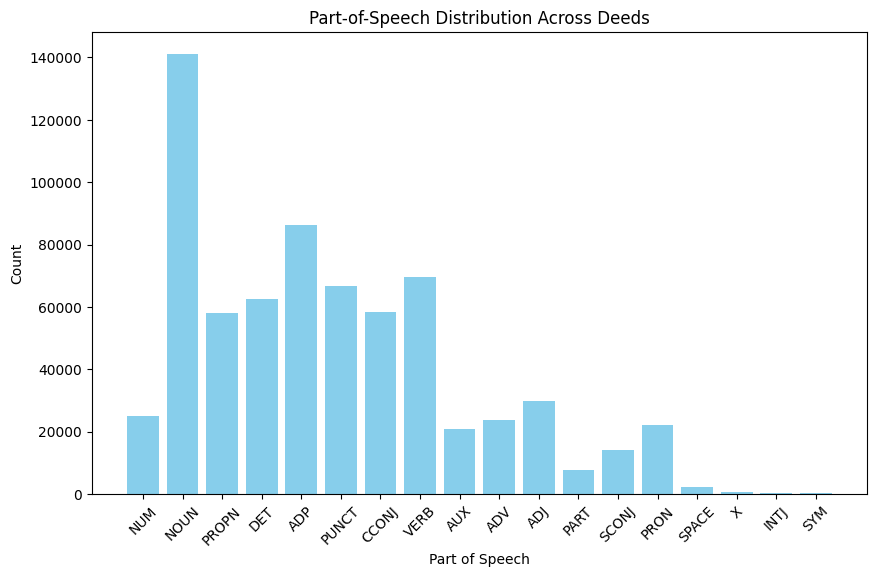

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

pos_counts = defaultdict(int)
for obj in text_objects:
    for pos, count in obj['pos_counts'].items():
        pos_counts[pos] += count

pos_df = pd.DataFrame(list(pos_counts.items()), columns=['POS', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(pos_df['POS'], pos_df['Count'], color='skyblue')
plt.title('Part-of-Speech Distribution Across Deeds')
plt.xlabel('Part of Speech')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The above graph shows how parts of speech are distributed across the dataset. Racism in the deeds tends to use national identifiers, like Polander or Italian, which would be identified as proper nouns. The graph shows there is limited proper noun usage, which may be a smaller search space to start with. Areas like punctuation, auxilary words, and propositions may be eliminated to reduce noise.

#### Named Entity Frequency

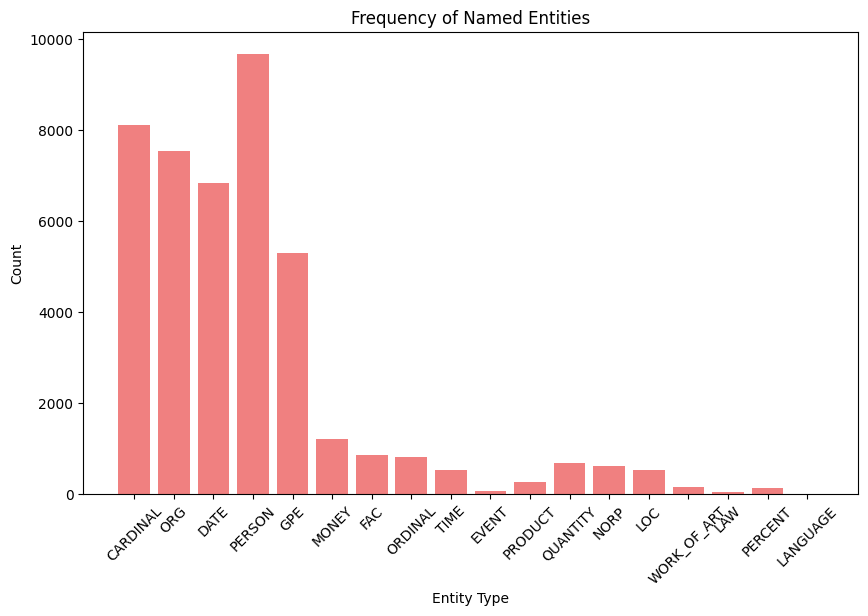

In [5]:
entity_counter = Counter()
for obj in text_objects:
    for ent in obj['named_entities']:
        entity_counter[ent['label']] += 1

entity_df = pd.DataFrame(entity_counter.items(), columns=['Entity Type', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(entity_df['Entity Type'], entity_df['Count'], color='lightcoral')
plt.title('Frequency of Named Entities')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Named might reveal patterns in the deeds related to specific groups of people or locations. If certain ethnic groups are mentioned explicitly or indirectly, we can look directly for that pattern in other deeds. The graph shows above that for this subset, there is nothing particularly interesting in the named entities field.

#### Topic Modeling with LDA

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

documents = [obj["original_text"] for obj in text_objects]

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(documents)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

num_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

Topic 1:
feet springfield street giantee 01 heus right hampden night oi
Topic 2:
feet street springfield giantee heus 01 line night seal hampden
Topic 3:
ball 01 night heus johnson hampden albert 1899 feet purchasers
Topic 4:
feet street springfield 01 line westerly giantee oi 1899 heus
Topic 5:
01 giantee heus night 1899 oi hampden seal executois purchasers


Cluster 1:
road kelley springfield james east rosa giantee 01 links rods
Cluster 2:
heus ellen giantee street 01 springfield arthur allen avenue feet
Cluster 3:
george grantees heus west giantee 01 line springfield street feet
Cluster 4:
hampden lot street heus springfield 01 lincoln giantee feet mary
Cluster 5:
right heus john line smith giantee 01 springfield street feet


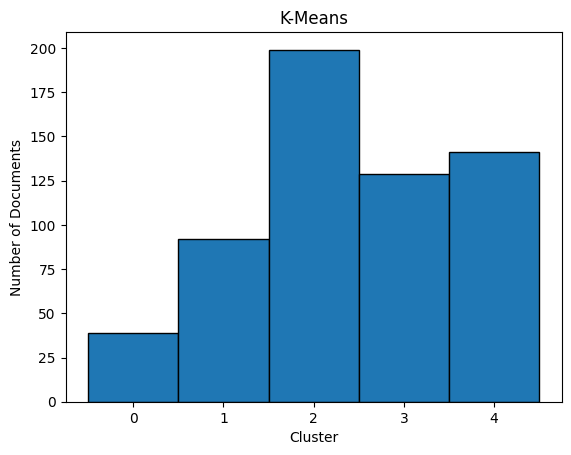

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i + 1}:")
    print(" ".join([terms[ind] for ind in km.cluster_centers_.argsort()[:, -10:][i]]))

labels = km.labels_
plt.hist(labels, bins=np.arange(num_clusters + 1) - 0.5, edgecolor='black')
plt.xticks(range(num_clusters))
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.title('K-Means')
plt.show()


The above scripts use LDA and KMeans to break the text down into 5 topics. As expected, the topics include words like feet and street which likely concerns delineating the purchased plots in the deeds.

#### Testing Bigotry Dictionary

Sentence containing 'Catholic':
Containing ten acres of land offerasite the Catholic Cemetery.
    Keyword  Count
4      race    138
3     white    112
0      pole     30
1      arab      9
2  catholic      2


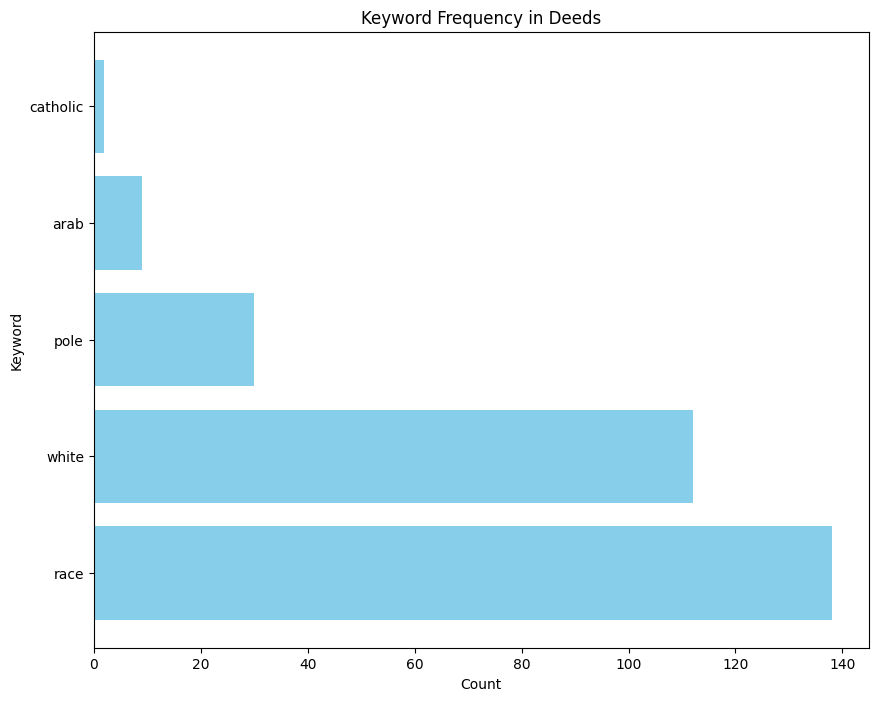

In [8]:
import pandas as pd
import sys
import os
import re

sys.path.append(os.path.abspath('../last_year'))
from bigotry_dict import bigotry_dict

def extract_sentence_with_keyword(text, keyword):
    pattern = re.compile(r'([^.]*\b' + re.escape(keyword) + r'\b[^.]*\.)', re.IGNORECASE)
    match = pattern.search(text)
    if match:
        return match.group(0).strip()
    return None

sentence_with_catholic = None
for text_obj in text_objects:
    sentence = extract_sentence_with_keyword(text_obj['original_text'], 'Catholic')
    if sentence:
        sentence_with_catholic = sentence
        break

if sentence_with_catholic:
    print(f"Sentence containing 'Catholic':\n{sentence_with_catholic}")
else:
    print("No sentence containing 'Catholic' was found.")

def count_keywords(text, bigotry_dict):
    keyword_counts = {keyword.lower(): 0 for keyword in bigotry_dict}
    text_lower = text.lower()

    for keyword in bigotry_dict:
        keyword_lower = keyword.lower()
        count = text_lower.count(keyword_lower)
        keyword_counts[keyword_lower] += count
    
    return keyword_counts

total_keyword_counts = {keyword.lower(): 0 for keyword in bigotry_dict}

for text_obj in text_objects:
    keyword_counts = count_keywords(text_obj['original_text'], bigotry_dict)
    
    for keyword_lower, count in keyword_counts.items():
        total_keyword_counts[keyword_lower] += count

keyword_df = pd.DataFrame([(keyword, count) for keyword, count in total_keyword_counts.items() if count > 0], 
                           columns=['Keyword', 'Count'])

keyword_df_sorted = keyword_df.sort_values(by="Count", ascending=False)

print(keyword_df_sorted)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(keyword_df_sorted['Keyword'], keyword_df_sorted['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Keyword Frequency in Deeds')
plt.show()


Searches through the text for the keywords in bigotry_dict. Accumulates the count for each word. (Identified words are names or small part of a longer word)

In [ ]:
import spacy
from bigotry_dict import bigotry_dict  
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

def named_entity_match(text, bigotry_dict):
    doc = nlp(text)
    named_entities = [ent.text.lower() for ent in doc.ents]
    keyword_counts = {keyword.lower(): 0 for keyword in bigotry_dict}

    for keyword in bigotry_dict:
        keyword_lower = keyword.lower()
        keyword_counts[keyword_lower] += named_entities.count(keyword_lower)

    return keyword_counts

total_keyword_counts = {}

for text_obj in text_objects:
    keyword_counts = named_entity_match(text_obj['original_text'], bigotry_dict)
    
    for keyword_lower, count in keyword_counts.items():
        if keyword_lower not in total_keyword_counts:
            total_keyword_counts[keyword_lower] = {'count': 0, 'original_keywords': []}
        total_keyword_counts[keyword_lower]['count'] += count
        if keyword_lower not in total_keyword_counts[keyword_lower]['original_keywords']:
            total_keyword_counts[keyword_lower]['original_keywords'].append(keyword_lower)

keyword_df = pd.DataFrame([(data['original_keywords'][0], data['count']) 
                           for data in total_keyword_counts.items()], 
                          columns=['Keyword', 'Count'])

keyword_df_sorted = keyword_df.sort_values(by="Count", ascending=False)

print(keyword_df_sorted)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(keyword_df_sorted['Keyword'], keyword_df_sorted['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Keyword Frequency in Named Entities')
plt.show()


Searches through the named entities for the keywords in bigotry_dict. Accumulates the count for each word. 

                 Keyword  Count  \
48                 white     56   
54                  race      3   
42              catholic      1   
1                  greek      0   
4                mutatto      0   
5               quadroon      0   
2              portugese      0   
3                mulatto      0   
0               irishman      0   
9                 hebrew      0   
10                  pole      0   
11       french canadian      0   
12              canadien      0   
13             quebecois      0   
14             quebecker      0   
15                  arab      0   
16                 arabs      0   
17                  truk      0   
18                 turks      0   
19             frenchman      0   
20                german      0   
21               germans      0   
6               chinaman      0   
7                    jap      0   
8                   japs      0   
24                  slav      0   
23             spaniards      0   
22              span

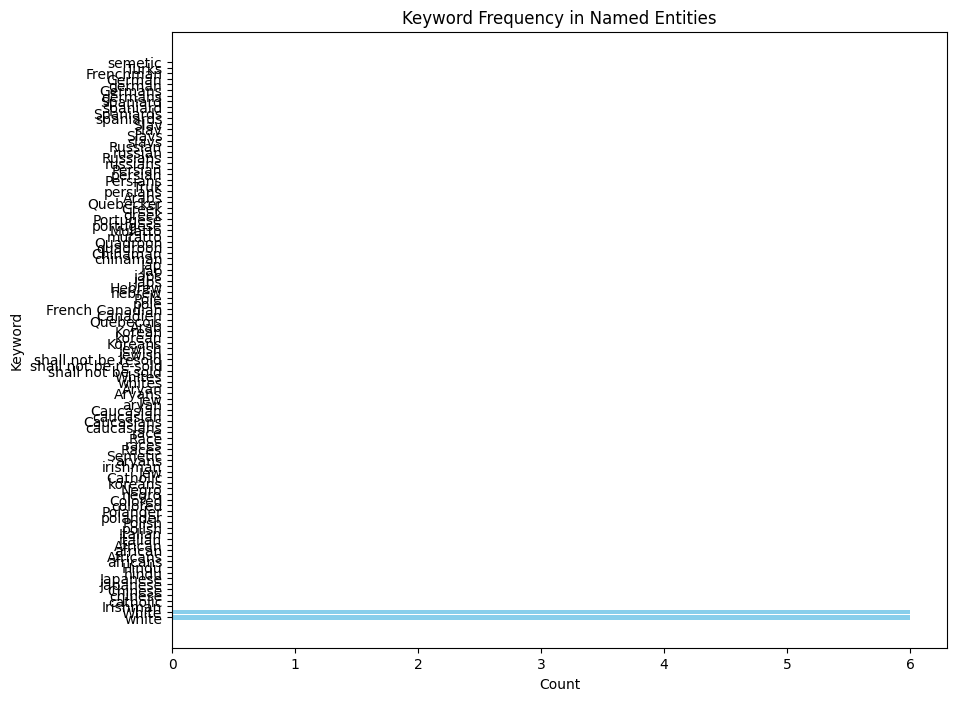

In [6]:
import spacy
from bigotry_dict import bigotry_dict
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

def count_keywords_entities(text, bigotry_dict):
    doc = nlp(text)
    keyword_counts = {keyword.lower(): {'count': 0, 'pos': []} for keyword in bigotry_dict}

    for token in doc:
        keyword_lower = token.text.lower()
        if keyword_lower in bigotry_dict:
            keyword_counts[keyword_lower]['count'] += 1
            keyword_counts[keyword_lower]['pos'].append(token.pos_)

    return keyword_counts

total_keyword_counts = {keyword: 0 for keyword in bigotry_dict}

for text_obj in text_objects:  
    keyword_counts = count_keywords_entities(text_obj['original_text'], bigotry_dict)
    
    for keyword, count in keyword_counts.items():
        total_keyword_counts[keyword] += count

keyword_df = pd.DataFrame(list(total_keyword_counts.items()), columns=['Keyword', 'Count'])

keyword_df_sorted = keyword_df.sort_values(by="Count", ascending=False)

print(keyword_df_sorted)

plt.figure(figsize=(10, 8))
plt.barh(keyword_df_sorted['Keyword'], keyword_df_sorted['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Keyword Frequency by POS in Texts')
plt.show()

Searches through the part of speech for the keywords in bigotry_dict. Accumulates the count for each word. 

The deeds in this batch do not contain racist language, so it is no surprise that both a brute force search and searching keywords yielded no results from the bigotry dictionary. Interstingly, there is a high frequency of the words "white" and "race" according to the bigotry dictionary. Further examination revealed that older names like "Grace" and "Horace" were triggering the word race.

### Conclusions

- OCR has a high degree of accuracy in turning the TIFF images into text
- Preprocessing techniques, like spellcheckers, may not be able to account for old English or national identifiers
- The bigotry dictionary yielded no actual racism, and instead flagged old names that included "white" or "race" as a substring
- spaCy can structured the parsed text into a more digestible object that we can use for analysis
- Named entities and pronouns extracted from the text will be most useful for detecting racism
- Structuring the text by parts of speech lets us eliminate unhelpful parts of speech, like propositions